<div style="text-align:center"><span style="font-size:2em; font-weight: bold;">Lecture 6—Simulation</span></div>

# Data Science: ARMA processes

## Definition

$$x_t=\rho_1x_{t-1}+\dots+\rho_px_{t-p}+e_t+\phi_1e_{t-1}+\dots+\phi_qe_{t-q}$$

## Simulation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

n = 1000
rho = np.array([0.75,0.05])
phi = np.array([0.25])
phi = np.concatenate((np.ones(1),phi))
m = max(len(rho),len(phi))
if len(rho)!=m: rho = np.concatenate((rho,np.zeros(shape=m-len(rho))))
if len(phi)!=m: phi = np.concatenate((phi,np.zeros(shape=m-len(phi))))
print(rho)
print(phi)

[0.75 0.05]
[1.   0.25]


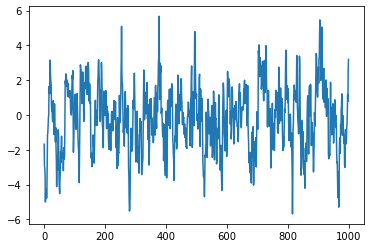

In [2]:
e = np.random.normal(size=n+100) ## 100 burn-in
x = e.copy()
for i in range(m+1,n+100):
    x[i] = x[i-1:i-m-1:-1]@rho+e[i:i-m:-1]@phi
x = x[100:] ## cut off the burn in
pd.Series(x).plot();

In [4]:
(x[1:]*x[:-1]).mean()/x.var()

0.8461235363489115

In [5]:
(x[2:]*x[:-2]).mean()/x.var()

0.6587236639594017

In [6]:
(x[3:]*x[:-3]).mean()/x.var()

0.5343897591059281

In [8]:
for i in range(1,10):
    print(i,(x[i:]*x[:-i]).mean()/x.var())

1 0.8461235363489115
2 0.6587236639594017
3 0.5343897591059281
4 0.45392722800500657
5 0.39591382308637535
6 0.3429690658973252
7 0.2894049902013099
8 0.24380048098507145
9 0.20523394414446464


# Endogeneity

## Derivation

### Definitions
**Definition (weak exogeneity)**

$$\mathbf E\left[e\middle|\mathbf X\right]=\mathbf 0$$

**Definition (strong endogeneity)**

$$\mathbf E\left[\mathbf X'e\right]\neq\mathbf 0$$

### Expected value of $\hat\beta$

$$
\begin{align}
\mathbf E\left[\hat\beta\right] &= \mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'y\right] \\
&= \mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'(\mathbf X\beta+e)\right] \\
&= \beta + \mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'e\right] \\
&= \beta + \mathbf E\left[\mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'e\middle|\mathbf X\right]\right] \\
&= \beta + \mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'\mathbf E\left[e\middle|\mathbf X\right]\right] \\
&= \beta + \mathbf E\left[\left(\mathbf X'\mathbf X\right)^{-1}\mathbf X'\mathbf 0\right] \\
&= \beta + \mathbf 0 = \beta \\
\end{align}
$$

$$\text{Bias}\left[\hat\beta\right]=\mathbf E\left[\hat\beta\right]-\beta=\mathbf 0$$

##  Sources

### Simulation without endogeneity

[2.001362   1.99994425 2.00035713 1.99977594 1.99934165]
[0.04539049 0.02149647 0.01014238 0.00404866 0.00198586]


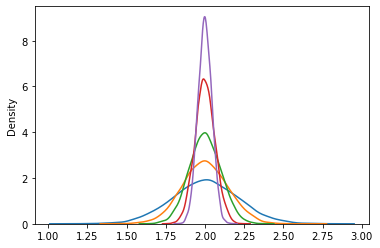

In [12]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        # Data generating process
        x = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + e
        # Running the models
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

### Omitted variable bias

[2.0049987  2.00389403 2.00238647 1.99914399 1.99745854]
[0.44484889 0.21217827 0.10438097 0.04075483 0.01993899]


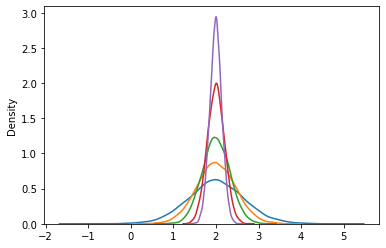

In [13]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        x = np.random.normal(size=(n,))
        z = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + 3*z + e
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

[3.49576347 3.49528495 3.49624593 3.49814016 3.49904004]
[0.3207169  0.15385999 0.07526717 0.02917353 0.01450226]


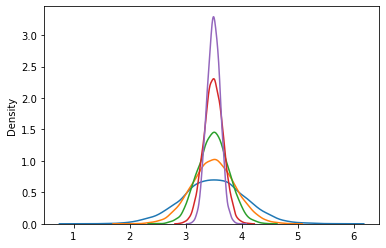

In [14]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        w = np.random.normal(size=(n,))
        x = w + np.random.normal(size=(n,))
        z = w + np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + 3*z + e
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

In [15]:
np.mean((x-x.mean())*(z-z.mean()))/np.std(x)/np.std(z)

0.4767187090595252

In [16]:
np.corrcoef(np.hstack([x.reshape(-1,1),z.reshape(-1,1)]).T)

array([[1.        , 0.47671871],
       [0.47671871, 1.        ]])

[2.00113995 1.99912705 2.00066693 2.00014775 1.99991192]
[0.03172321 0.01420708 0.00690126 0.00271348 0.00134435]


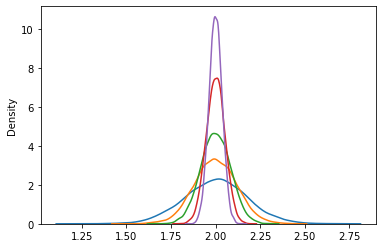

In [17]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        w = np.random.normal(size=(n,))
        x = w + np.random.normal(size=(n,))
        z = w + np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + 3*z + e
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1),z.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

### Measurement error bias

[1.00328797 0.99936682 0.99985463 1.00204159 1.00039686]
[0.09233374 0.04262041 0.02066303 0.00817189 0.00403139]


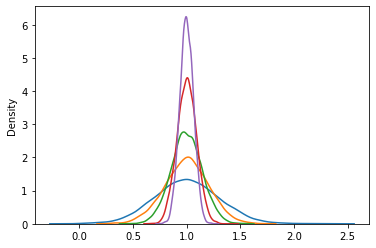

In [18]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        x = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + e
        xs = x + np.random.normal(size=(n,))
        ys = y + np.random.normal(size=(n,))
        ones = np.ones([n,1])
        xo = np.hstack([ones,xs.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@ys)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

[1.00030463 0.99761177 0.99775537 1.00064766 0.99950429]
[0.06684758 0.03147151 0.01547284 0.00620102 0.00305093]


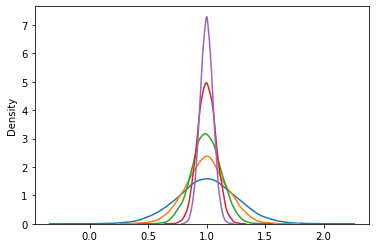

In [19]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        x = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + e
        xs = x + np.random.normal(size=(n,))
        ys = y + np.random.normal(size=(n,))
        ones = np.ones([n,1])
        xo = np.hstack([ones,xs.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

[1.99653401 2.00080211 1.99721886 2.00045943 1.99907982]
[0.08946044 0.04249959 0.02039395 0.00817244 0.00406775]


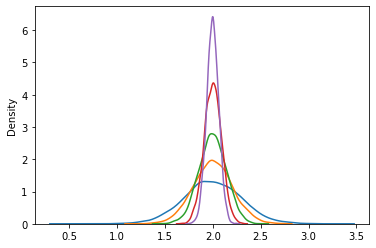

In [20]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        x = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + e
        xs = x + np.random.normal(size=(n,))
        ys = y + np.random.normal(size=(n,))
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@ys)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

### Reverse regression bias

[0.39973204 0.39968974 0.39972916 0.39976538 0.40009409]
[1.78893932e-03 8.45708239e-04 4.14261674e-04 1.63620319e-04
 8.10573016e-05]


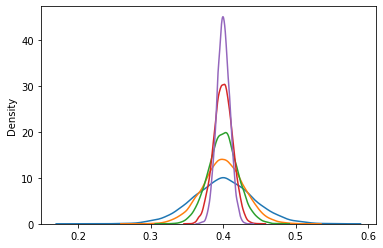

In [21]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        x = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        y = 1 + 2*x + e
        ones = np.ones([n,1])
        yo = np.hstack([ones,y.reshape(-1,1)])
        g = np.linalg.solve(yo.T@yo,yo.T@x)
        outp[isim,ns] = g[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

### Simultaneity bias

[1.49930709 1.50124431 1.4997878  1.49989951 1.49985967]
[0.01128671 0.00515524 0.00256606 0.00101681 0.00050318]


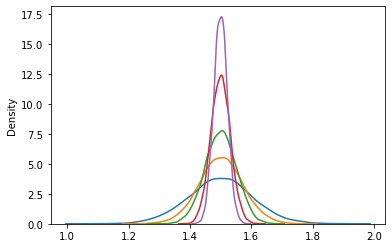

In [22]:
nsim = 10000
nvec = [25,50,100,250,500]
outp = np.zeros([nsim,len(nvec)])
for ns in range(len(nvec)):
    n = nvec[ns]
    for isim in range(nsim):
        u = np.random.normal(size=(n,))
        e = np.random.normal(size=(n,))
        x = -1 - e - u
        y = 1 + 2*x + e
        # x = y + u
        ones = np.ones([n,1])
        xo = np.hstack([ones,x.reshape(-1,1)])
        b = np.linalg.solve(xo.T@xo,xo.T@y)
        outp[isim,ns] = b[1]
print(outp.mean(0))
print(outp.var(0))
for ns in range(len(nvec)):
    sns.kdeplot(outp[:,ns],label=nvec[ns])

# Programming challenges

## Spurious regression

Write a simulation that shows the R-squared statistics for spurious regressions

x and y should both be nonstationary. x and y should be 100% independent of each other. Everything else you decide.

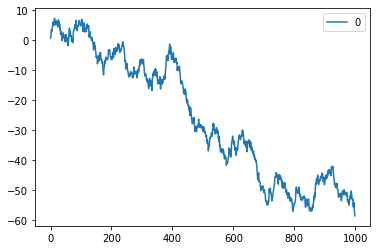

In [24]:
n = 1000
x = np.random.normal(size=(n,))
for i in range(1,n):
    x[i] = x[i-1]+x[i]
pd.DataFrame(x).plot();

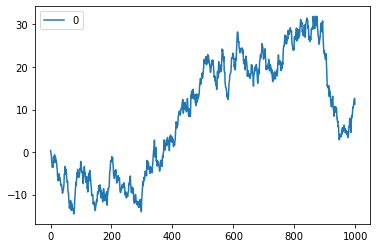

In [32]:
x = np.random.normal(size=(n,))
x = x.cumsum()
pd.DataFrame(x).plot();

# Exam 1 Review

## Details
- March 20-27th
- 3 hours
- Honorlock (lockdown browser)
- No cell phone or computer to execute python code
- Lectures 1 and 2, look at programming challenges
- Open book open note (paper notes)

## Question 1: Write some code
Difficulty level: FizzBuzz (1 loop)
## Question 2: Output some code
Pretend you are the python interpreter and I give you the code, tell me what it will output

Difficulty level: Hailstone (2 loop) Not problem set, the one from the programming challenges
## Question 3: Correct some code
Difficulty level: Pascal's triangle

I will give you the code and what it is supposed to output. You tell me the line number of the errors.

4 errors in the code

Tell me where to fix the problem (not where the error message is)